# Sequential test simulations

Let us present simulations of five (mostly) sequential parametric tests.

Consider Bernoulli random variables $X_1,X_2,...$ iid Alt($p$)

We always aim to test the hypothesis

H0: $p = p_0$

against the alternative

H1: $p = p_1$,

where $0 < p_0 < p_1 < 1$.

The tests can however be used to test the hypotheses H0: $p<= p_0$ versus H1: $p>=p_1$.

The idea of the code is that a *test#* function returns *False* if H0 was NOT rejected and *True* if the test DID reject H0 in favour of H1.

On top of vanilla python 3, the code uses
- *numpy* for general math,
- *scipy.stats* for binomial quantiles,
- *matplotlib.pyplot* for image generation.

In [4]:
# import libraries
import math
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

In [5]:
# auxiliary functions
def gen_X( p ):
    '''
    draw Xi from the pre-specified distribution
    with the parameter value set to 'p'
    '''
    r = np.random.uniform( 0.0, 1.0, 1 )
    return( r < p )

def choose( j, n ):
    return math.factorial( n ) / ( math.factorial( j ) * math.factorial( n-j ) )

## 1) Test with fixed sample size

In [32]:
def L1( p, k, n ):
    '''
    probability of accepting H0 if the true value of the parameter is p a.k.a. operational characteristic
    '''
    return sum( choose( j, n ) * p**j * ( 1-p )**( n-j ) for j in range( int(k+1) ) )

def eval_k( n, p0, alpha ):
    return binom.ppf( 1-alpha, n, p0 )

In [36]:
n = 100
alpha = 0.05
p = 0.10
p0 = 0.10
p1 = 0.15

In [37]:
def test1( k, verbose = False ):
    x = np.array( [ gen_X( p ) for i in range( n ) ] ) # draw the sample
    Sn = np.sum( x ) # compute test statistic
    L = L1( p, k, n ) # compute operational characteristic
    if verbose:
        print( 'data = \n', np.where( x, 1, 0 ).reshape( -1, 20 ) )
        print( 'Sn = ', Sn )
        print( 'k = ', k)
        print( 'L1 = ', L)
    return( Sn > k) # True - rejected H0, False - not rejected

In [38]:
H = test1( eval_k( n, p0, alpha ), verbose = True )
print( H )

data = 
 [[0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0]]
Sn =  11
k =  15.0
L1 =  0.9601094728889192
False


Let us see if the level of the test really holds after some more tries:

In [10]:
lvl = 0
for i in range( 1000 ):
    H = test1( eval_k( n, p0, alpha ) )
    if( H ): lvl += 1

print( lvl/1000 )

0.036


And let us take a look at the operational characteristic of this test:

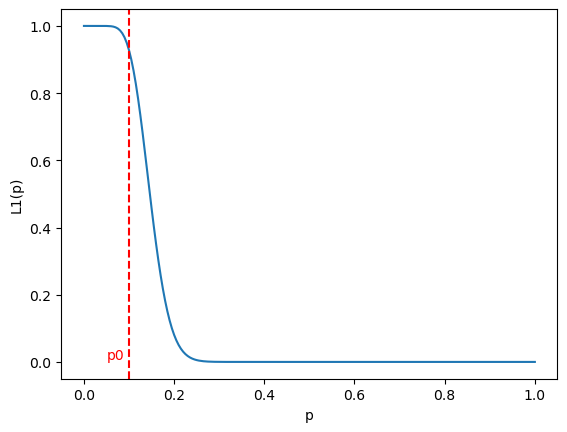

In [11]:
arr_p = np.linspace( 0, 1, 201 )
arr_L = L1( arr_p, eval_k( n, p0, alpha ), n )

plt.plot( arr_p, arr_L )
plt.axvline( x=p0, color='red', linestyle='--' )
plt.xlabel( 'p' )
plt.ylabel( 'L1(p)' )
plt.text(p0-0.01, 0, 'p0', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.show()

We observe a non-increasing function with values between 0 and 1.

It approximately holds that $L_1(p_0)=1-\alpha$, i.e. **P**(type 1 error, $p_0$)=$\alpha$.

## 2) Two-stage test

In [12]:
n1 = 50
n2 = 50

p = 0.45
p0 = 0.30
p1 = 0.70

def eval_a( n, p0, alpha ):
    return binom.ppf( 1-alpha/2, n, p0 )

def eval_b( n, p1, alpha ):
    return binom.ppf( alpha/2, n, p1 )

def L2( p, a, b, n1, n2 ):
    return L1( p, a, n1 ) + sum( choose( j, n1 ) * p**j * ( 1-p )**( n1-j ) * L1( p, b-j, n2 ) for j in range( int(a+1), int(b) ) )

def EN( p, n1, n2, alpha ):
    a = eval_a( n1, p0, alpha )
    b = eval_b( n1, p1, alpha )
    # print( round( L1( p, b, n1 ), 4 ), round( L1( p, a, n1 ), 4 ) )
    return n1 + n2*( L1( p, b, n1 ) - L1( p, a, n1) )

def test2( n1, n2, alpha, p0, p1, verbose=False ):
    a = eval_a( n1, p0, alpha )
    b = eval_b( n2, p1, alpha )
    x = np.array( [ gen_X( p ) for i in range( n1 ) ] ) # draw the sample
    Sn = np.sum( x ) # test statistic
    if verbose: print( 'Stage one:\na =', a, ', b =', b, ', Sn =', Sn )
    if( Sn <= a ): return False
    elif( Sn > b ): return True
    else:
        x = np.append( x, np.array( [ gen_X( p ) for i in range( n2 ) ] ) ) # extend the sample
        b = eval_b( n1+n2, p1, alpha )
        Sn = np.sum( x ) # recalculate test statistic
        if verbose: print( 'Stage two:\nb =', b, ', Sn =', Sn)
        if( Sn <= b ): return False
        else: return True

In [13]:
print( test2( n1, n2, alpha, p0, p1, verbose = True ) )
print( 'EN =', round( EN( p, n1, n2, alpha ), ndigits = 4) )

Stage one:
a = 22.0 , b = 28.0 , Sn = 21
False
EN = 76.6038


Let us examine the expected sample size for different values of *p*:

In [14]:
arr_p = np.linspace( 0, 1, 201 )
arr_EN = EN( arr_p, n1, n2, alpha )

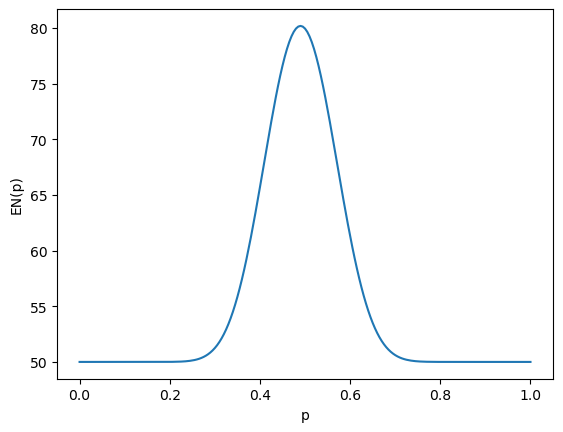

In [15]:
plt.plot( arr_p, arr_EN )
plt.xlabel( 'p' )
plt.ylabel( 'EN(p)' )
plt.show()

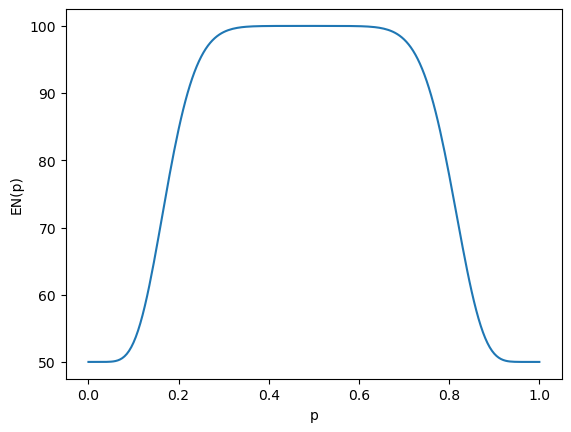

In [16]:
p0 = 0.10
p1 = 0.90

arr_p = np.linspace( 0, 1, 201 )
arr_EN = EN( arr_p, n1, n2, alpha )

plt.plot( arr_p, arr_EN )
plt.xlabel( 'p' )
plt.ylabel( 'EN(p)' )
plt.show()

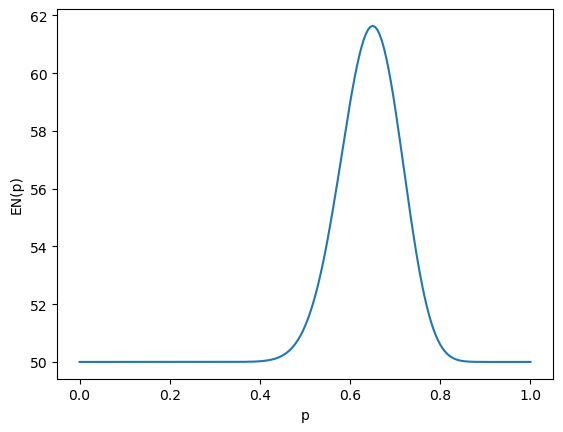

In [17]:
p0 = 0.50
p1 = 0.80

arr_p = np.linspace( 0, 1, 201 )
arr_EN = EN( arr_p, n1, n2, alpha )

plt.plot( arr_p, arr_EN )
plt.xlabel( 'p' )
plt.ylabel( 'EN(p)' )
plt.show()

The function ranges between $n_1$ and $n_1+n_2$.

It has a maximum at the average of $p_0$ and $p_1$.

# 3) Curtailed-sampling test

Select maximum sample size *N*. Select $c$.

We first draw $X_1,...,X_n$, compute $S_n$ as a sum of them.

Reject H0 if the $S_n \geq c$. If not, draw $X_{n+1}$, recalculate $S_n$.

From now on, the rejection rule is $S_n = c$. Repeat until rejection or until *n==N*.

In [18]:
def eval_c( N, p0, alpha ):
    return binom.ppf( 1-alpha, N, p0 )

def L3( p, c, N ):
    return sum( choose( d, N ) * p**d * (1-p)**(N-d) for d in range( int(c) ) )

def EN3( p, c, N ):
    k1 = c/p * sum( choose( d, N+1 ) * p**d * (1-p)**(N+1-d) for d in range( int(c+1), int(N+2) ) )
    k2 = (N+1-c) / (1-p) * sum( choose( d, N+1 ) * p**d * (1-p)**(N+1-d) for d in range( int(c) ) )
    return k1 + k2

def test3( n, N, p0, alpha, verbose = False ):
    c = eval_c( N, p0, alpha )
    x = np.array( [ gen_X( p ) for i in range( n ) ] ) # draw the sample
    Sn = np.sum( x ) # test statistic
    while n < N and Sn <= c: # while not rejected
        if( Sn == c ):
            if verbose:
                print( 'Sample of size', n )
                print( 'c =', int(c) )
                print( 'Sn =', Sn )
                print( 'L3 =', np.round( L3( p, c, N ), decimals = 3 ) )
            return True
        else:
            x = np.append( x, gen_X( p ) ) # extend sample with Xn+1
            Sn = sum( x )
            n += 1
    if verbose:
        print( 'Sample of size', n )
        print( 'c =', c )
        print( 'Sn =', Sn )
        print( 'L3 =', np.round( L3( p, c, N ), decimals = 3 ) )
    return False

In [19]:
N = 200 # maximum sample size
n = 20 # initial sample size

p0 = 0.30
p1 = 0.50
alpha = 0.05

p = 0.30

print( test3( n, N, p0, alpha, verbose = True ) )

Sample of size 200
c = 71.0
Sn = 60
L3 = 0.946
False


The operational characteristic is not very different from the previous ones:

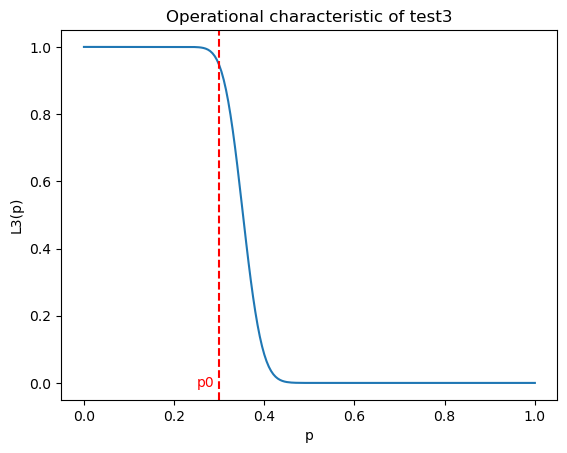

In [20]:
arr_p = np.linspace( 0, 1, 201 )
arr_L = L3( arr_p, eval_c( N, p0, alpha ), N )

# plot of the operational characteristic
plt.plot( arr_p, arr_L )
plt.axvline( x=p0, color='red', linestyle='--' )
plt.text( p0-0.01, -0.02, 'p0', color='red', verticalalignment='bottom', horizontalalignment='right' )
plt.xlabel( 'p' )
plt.ylabel( 'L3(p)' )
plt.title( 'Operational characteristic of test3' )
plt.show()

The expected sample size is however very different:

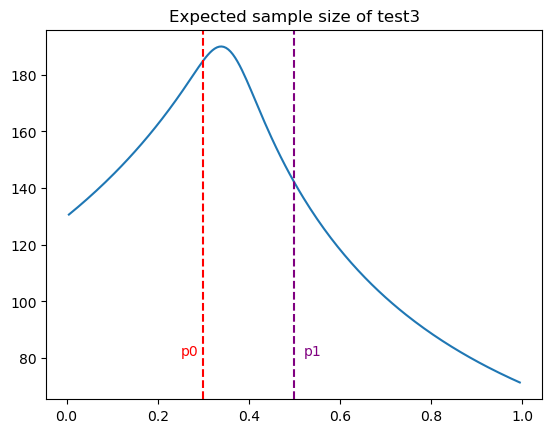

In [21]:
arr_p = np.linspace( 0.005, 0.995, 199 ) # funnily enough, 0 and 1 result in divide by zero exception
c = eval_c( N, p0, alpha )
arr_EN3 = EN3( arr_p, c, N )

# plot of expected sample size
plt.plot( arr_p, arr_EN3 )
plt.axvline( x=p0, color='red', linestyle='--' )
plt.text( p0-0.01, 80, 'p0', color='red', verticalalignment='bottom', horizontalalignment='right' )
plt.axvline( x=p1, color='purple', linestyle='--' )
plt.text( p1+0.02, 80, 'p1', color='purple', verticalalignment='bottom', horizontalalignment='left' )
plt.title( 'Expected sample size of test3' )
plt.show()

# 4) Wald sequential test

The idea is to first draw a sample of size *n* and see if we can decide. If not, draw another variable and repeat until one of the critical inequalities is violated. This will happen with probability 1.

In [22]:
n = 10

alpha = 0.05
beta = 0.05

p0 = 0.40
p1 = 0.41

a = math.log( (1-beta) / alpha )
b = math.log( beta / (1-alpha) )

ha = a / math.log( (p1*(1-p0)) / (p0*(1-p1)) )
hb = b / math.log( (p1*(1-p0)) / (p0*(1-p1)) )

s = math.log( (1-p0)/(1-p1) ) / math.log( (p1*(1-p0)) / (p0*(1-p1)) )


def test4( p, n_init, n_add = 1, verbose = False ):
    counter = 1
    x = np.array( [ gen_X( p ) for i in range( n_init ) ] )
    while hb + (n*counter)*s < sum( x ) and sum( x ) < ha + (n*counter)*s:
        counter += 1
        x = np.append( x, np.array( [ gen_X( p ) for i in range( n_add ) ] ) ) # extend the sample
    if verbose:
        print( 'data = \n', np.where( x, 1, 0 ) )
        print( counter-1, 'sample extensions required' )
    if sum( x ) < hb + (n*counter)*s: return False
    else: return True

In [23]:
print( test4( 0.45, n_init = 10, verbose = True ) )

data = 
 [0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0]
19 sample extensions required
False


# 5) Wald curtailed test

A combintation of tests 3) and 4).

`while( n < N ):
    do Wald sequential test
decide`

In [24]:
def test5( p, N, n=1, verbose = False ): # (n*counter) is the sample size after extension
    counter = 1
    x = np.array( [ gen_X( p ) for i in range( n ) ] )
    while hb + (n*counter)*s < sum( x ) and sum( x ) < ha + (n*counter)*s:
        counter += 1
        x = np.append( x, np.array( [ gen_X( p ) for i in range( n ) ] ) ) # extend the sample
        if n*counter >= N: break
        else: pass
    if verbose:
        print( 'data = \n', np.where( x, 1, 0 ) )
        print( counter-1, 'sample extensions required' )
        if( n*counter >= N ): print( 'Stopped at limit N =', N )
        else: print( 'Stopped naturally' )
    if( n*counter >= N ): # limit reached
        if sum( x ) < len( x ) * s: return False
        else: return True
    elif sum( x ) < hb + (n*counter)*s: return False # rule from test4
    else: return True

In [25]:
p0 = 0.45
p1 = 0.50

alpha = 0.05
beta = 0.05

a = math.log( (1-beta) / alpha )
b = math.log( beta / (1-alpha) )

ha = a / math.log( (p1*(1-p0)) / (p0*(1-p1)) )
hb = b / math.log( (p1*(1-p0)) / (p0*(1-p1)) )

s = math.log( (1-p0)/(1-p1) ) / math.log( (p1*(1-p0)) / (p0*(1-p1)) )

print( test5( 0.45, N = 500, verbose = True ) )

data = 
 [1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0
 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0
 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0
 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0
 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1
 1 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1
 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1
 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 1 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0
 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 1
 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0
 0 1 0 1 1 0 1 0

# 6) Wald test for groups

The test works similarly to the ordinary Wald sequential test, but the sample is generally extended by a group of random variables *Xn+1,...,Xn+k*.

In the code, simply set *n_add* = desired group size.

The following example is motivated by the origin of Wald sequential test. The goal was to determine the percentage of faulty Flak shots in a batch.

More precisely, we aim to test

H0: $p\leq p_0$

against

H1: $p\geq p_1$.

We can only imagine what the real quantities were, so we assumed the initial sample size could have been *n=30* and the acceptable faulty rate, say, 3 %.

In [26]:
p0 = 0.03
p1 = 0.04

a = math.log( (1-beta) / alpha )
b = math.log( beta / (1-alpha) )

ha = a / math.log( (p1*(1-p0)) / (p0*(1-p1)) )
hb = b / math.log( (p1*(1-p0)) / (p0*(1-p1)) )

s = math.log( (1-p0)/(1-p1) ) / math.log( (p1*(1-p0)) / (p0*(1-p1)) )

p = np.random.uniform( 0.00, 0.08, 1 )
print( p )

print( test4( p, n_init = 30, n_add = 5, verbose = True ) ) # first draw 10, if not decided, extend the sample by five

[0.05525787]
data = 
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 

# Side note: Comparison of the tests

We have now introduced a lot of tests. Let us see how they perform copmared to each other.

[0.966 0.978 0.925 1.   ]


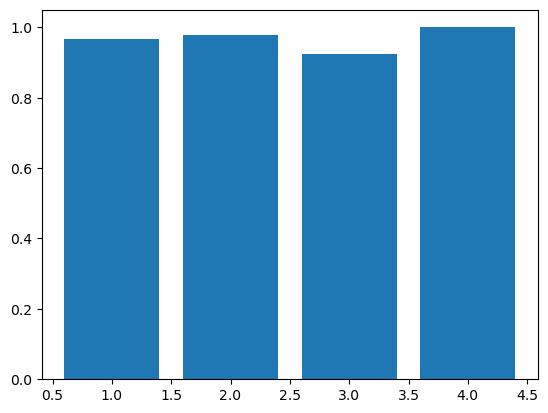

In [58]:
p = 0.10

p0 = 0.10
p1 = 0.15

alpha = 0.05
beta = 0.05

a = math.log( (1-beta) / alpha )
b = math.log( beta / (1-alpha) )

ha = a / math.log( (p1*(1-p0)) / (p0*(1-p1)) )
hb = b / math.log( (p1*(1-p0)) / (p0*(1-p1)) )

s = math.log( (1-p0)/(1-p1) ) / math.log( (p1*(1-p0)) / (p0*(1-p1)) )

arr_res1 = np.array( [ test1( eval_k( n = 100, p0 = p0, alpha = 0.05) ) for _ in range(1000) ] )
arr_res2 = np.array( [ test2( n1 = 50, n2 = 50, alpha = 0.05, p0 = p0, p1 = p1 ) for _ in range(1000) ] )
arr_res3 = np.array( [ test3( n =20, N = 100, p0 = p0, alpha = 0.05 ) for _ in range(1000) ] )
arr_res4 = np.array( [ test4( p = 0.10, n_init = 20, n_add = 1 ) for _ in range(1000) ] )

y1 = ( 1000 - np.sum( arr_res1 ) ) / 1000
y2 = ( 1000 - np.sum( arr_res2 ) ) / 1000
y3 = ( 1000 - np.sum( arr_res3 ) ) / 1000
y4 = ( 1000 - np.sum( arr_res4 ) ) / 1000

arr_x = np.array( [ 1, 2, 3, 4 ] )
arr_y = np.array( [ y1, y2, y3, y4 ] )

print( arr_y )

plt.bar( arr_x, arr_y )
plt.show()

Next up, we have some

# 7) Tests about variance of a normal distribution

The goal is now to test

H0: $\sigma^2=\sigma^2_0$

against

H1: $\sigma^2=\sigma^2_1$.

First, we assume our random sample to have been drawn from N$(\mu,\sigma^2)$, where $\mu$ is known in prior.

In [30]:
def testN1( ha, hb, s, mu, sigma, n = 1, verbose = False ):
    counter = 1
    x = np.random.normal( mu, math.sqrt(sigma), size = n )
    while hb + (n*counter)*s < sum( (x-mu)**2 ) and sum( (x-mu)**2 ) < ha + (n*counter)*s:
        counter += 1
        x = np.append( x, np.random.normal( mu, math.sqrt(sigma), size = n ) ) # extend the sample
    if verbose:
        print( 'data = \n', np.round( x, decimals = 3 ).reshape( -1, n ) )
        print( counter-1, 'sample extensions required' )
    if sum( (x-mu)**2 ) < hb + (n*counter)*s: return False
    else: return True

In [32]:
alpha = 0.05
beta = 0.05

mu = 0
sigma = 4

sigma0 = 1
sigma1 = 4

a = math.log( (1-beta) / alpha )
b = math.log( beta / (1-alpha) )

ha = 2*a / ( sigma0**(-2) - sigma1**(-2) )
hb = 2*b / ( sigma0**(-2) - sigma1**(-2) )
s = 2*math.log( sigma1/sigma0) / ( sigma0**(-2) - sigma1**(-2) )

n = 5

print( testN1( ha, hb, s, mu, sigma, n = 5, verbose = True ) )

data = 
 [[-1.003  2.561 -1.534  1.597 -0.171]
 [-3.495 -3.749  0.078  1.393  0.956]]
1 sample extensions required
True


It is however not necessary to know $\mu$ in advance. Just run the following test and see yourself.

In [44]:
def testN2( ha, hb, s, mu, sigma, n = 1, verbose = False ):
    counter = 1
    x = np.random.normal( mu, math.sqrt(sigma), size = n )
    while hb + (n*counter)*s < sum( ( x - np.mean(x) )**2 ) and sum( ( x - np.mean(x) )**2 ) < ha + (n*counter)*s:
        counter += 1
        x = np.append( x, np.random.normal( mu, math.sqrt(sigma), size = n ) ) # extend the sample
    if verbose:
        print( 'data = \n', np.round( x, decimals = 3 ) )
        print( counter-1, 'sample extensions required' )
    if sum( ( x - np.mean(x) )**2 ) < hb + (n*counter)*s: return False
    else: return True

In [45]:
alpha = 0.05
beta = 0.05

sigma = 4

sigma0 = 1
sigma1 = 4

a = math.log( (1-beta) / alpha )
b = math.log( beta / (1-alpha) )

ha = 2*a / ( sigma0**(-2) - sigma1**(-2) )
hb = 2*b / ( sigma0**(-2) - sigma1**(-2) )
s = 2*math.log( sigma1/sigma0) / ( sigma0**(-2) - sigma1**(-2) )

mu = np.random.uniform( 0.0, 100.0, 1) # so that mu is truly unknown
print( testN1( ha, hb, s, mu, sigma, n = 5, verbose = True ) )

data = 
 [[92.564 93.951 95.23  90.584 96.675]]
0 sample extensions required
True
